In [13]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ecg123:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5443725%2F9031648%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240725%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240725T104233Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3b87645485c11cd46dcedeeadcc5073c8a7913a91eafac008e44e8c7061c5c243d0143dfec2b2a0270ae527befac4d10b4f70042e8127c8bd5522134f91571a1b09aafca8a85497a64df334c6ccf5a1cfe34a9fec3eec1e6ca00c371dfce790915b64b08c6a10c7553b6488255817c049ee62f6bb60a64e33fa32b99b00e9141e3c0268a52e41d2bd85529f56d4a18d748c0fd00395881418e04de3b3afe946a3a99af20b633b53765973567c979936b6dc44ea0cad2fba37943ef9025e23dd8f73e630ab41f47fde92204fb8eaa6ca5caf657ec92a076f37029c4c49328e20018297d883b60e186ac616eb941f71ab2a642a9b6164f1623685bceca29fd298e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3437364 bytes downloaded
Downloaded and uncompressed: ecg123
Data source import complete.


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


In [15]:
dataframe=pd.read_csv('/kaggle/input/ecg123/ecg.csv',header=None)
raw_data=dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [16]:
labels=raw_data[:,-1]

data=raw_data[:,0:-1]
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.2,random_state=21)
min_val=tf.reduce_min(train_data)
max_val=tf.reduce_max(train_data)
test_data=(test_data-min_val)/(max_val-min_val)
train_data=tf.cast(train_data,tf.float32)
test_data=tf.cast(test_data,tf.float32)
test_data.dtype

tf.float32

In [17]:
labels=raw_data[:,-1]
data=raw_data[:,0:-1]
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.2,random_state=21)

In [18]:
min_val=tf.reduce_min(train_data)
max_val=tf.reduce_max(train_data)
train_data=(train_data-min_val)/(max_val-min_val)
test_data=(test_data-min_val)/(max_val-min_val)
train_data=tf.cast(train_data,tf.float32)
test_data=tf.cast(test_data,tf.float32)
test_data.dtype

tf.float32

In [19]:
trian_labels=train_labels.astype(bool)
test_labels=test_labels.astype(bool)

normal_train_data = train_data[train_labels==True]
normal_test_data = test_data[test_labels==True]

anomalous_train_data = train_data[train_labels==False]
anomalous_test_data = test_data[test_labels==False]
normal_test_data

<tf.Tensor: shape=(560, 140), dtype=float32, numpy=
array([[0.48035768, 0.28877792, 0.19828546, ..., 0.45463306, 0.5246125 ,
        0.3713729 ],
       [0.45354807, 0.2557325 , 0.15979648, ..., 0.4801337 , 0.5284734 ,
        0.49527124],
       [0.4521779 , 0.25685105, 0.12592098, ..., 0.55448556, 0.5861353 ,
        0.4754273 ],
       ...,
       [0.48304972, 0.36122933, 0.27729514, ..., 0.32799056, 0.3158066 ,
        0.26930442],
       [0.4090865 , 0.27907097, 0.22604261, ..., 0.39099607, 0.45987615,
        0.42140076],
       [0.42648116, 0.17669384, 0.14546008, ..., 0.4733389 , 0.55036914,
        0.37805188]], dtype=float32)>

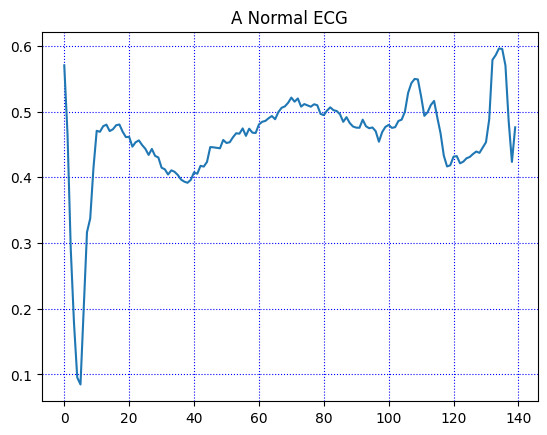

In [20]:
plt.grid(linestyle=":",color="b")
plt.plot(np.arange(140),normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

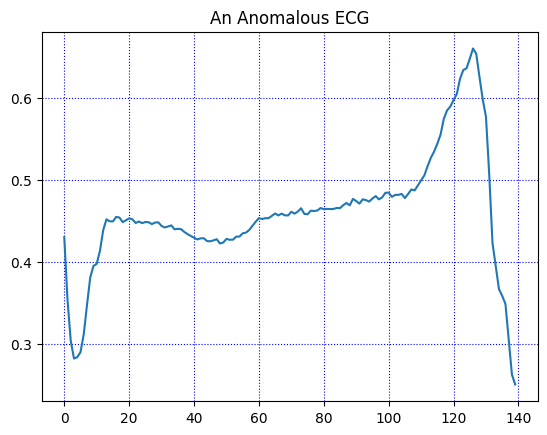

In [21]:
plt.grid(linestyle=":",color="b")
plt.plot(np.arange(140),anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [24]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder=tf.keras.Sequential([layers.Dense(32,activation="relu"),layers.Dense(16,activation="relu"),layers.Dense(8,activation="relu")])
        self.decoder=tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])
    def call(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(x)
        return decoded
autoencoder=AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')
history=autoencoder.fit(normal_train_data,normal_train_data,epochs=20,batch_size=512,
                       validation_data=(test_data,test_data),shuffle=True)

Epoch 1/20


5/5 [==============================] - 4s 209ms/step - loss: 0.0604 - val_loss: 0.0538
Epoch 2/20
5/5 [==============================] - 0s 38ms/step - loss: 0.0558 - val_loss: 0.0514
Epoch 3/20
5/5 [==============================] - 0s 56ms/step - loss: 0.0530 - val_loss: 0.0497
Epoch 4/20
5/5 [==============================] - 0s 90ms/step - loss: 0.0501 - val_loss: 0.0485
Epoch 5/20
5/5 [==============================] - 0s 29ms/step - loss: 0.0471 - val_loss: 0.0466
Epoch 6/20
5/5 [==============================] - 0s 55ms/step - loss: 0.0439 - val_loss: 0.0446
Epoch 7/20
5/5 [==============================] - 0s 70ms/step - loss: 0.0407 - val_loss: 0.0432
Epoch 8/20
5/5 [==============================] - 0s 52ms/step - loss: 0.0376 - val_loss: 0.0421
Epoch 9/20
5/5 [==============================] - 0s 41ms/step - loss: 0.0348 - val_loss: 0.0408
Epoch 10/20
5/5 [==============================] - 0s 42ms/step - loss: 0.0322 - val_loss: 0.0401
Epoch 11/20
5/5 [======================

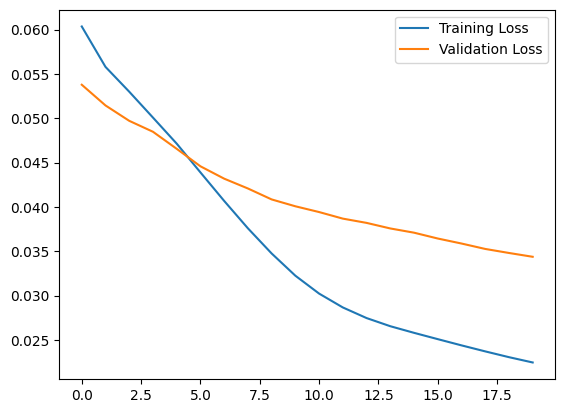

In [25]:
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()

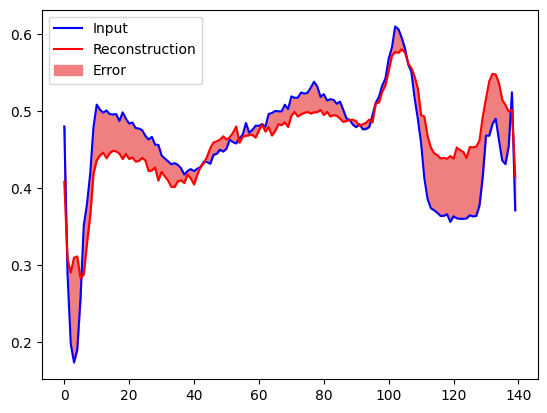

array([[0.3340602 , 0.728562  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3417888 , 0.67760944, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.29160106, 0.5936144 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.30678284, 0.7088958 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.34140077, 0.7607264 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33236456, 0.6627805 , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [26]:
encoded_imgs=autoencoder.encoder(normal_test_data).numpy()
decoded_imgs=autoencoder.decoder(normal_test_data).numpy()
plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140),decoded_imgs[0],normal_test_data[0],color='lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()
encoded_imgs

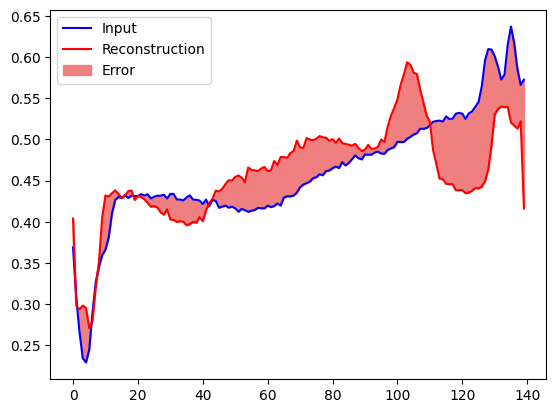

In [27]:
encoded_imgs=autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs=autoencoder.decoder(anomalous_test_data).numpy()
plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140),decoded_imgs[0],anomalous_test_data[0],color='lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()


In [28]:
reconstructions=autoencoder.predict(normal_train_data)
reconstructions

74/74 [==============================] - 0s 2ms/step


array([[0.40925092, 0.3076584 , 0.29820785, ..., 0.5088103 , 0.5167189 ,
        0.41963091],
       [0.40627223, 0.30381376, 0.29181305, ..., 0.5069984 , 0.50960004,
        0.41621497],
       [0.40475678, 0.29997483, 0.29375806, ..., 0.5124522 , 0.52079284,
        0.41651216],
       ...,
       [0.40554065, 0.30142274, 0.29100958, ..., 0.5086879 , 0.51364845,
        0.41599837],
       [0.40613553, 0.30401784, 0.29724294, ..., 0.5114031 , 0.51794857,
        0.41761553],
       [0.40388146, 0.29784834, 0.28778094, ..., 0.50943094, 0.5147137 ,
        0.4145865 ]], dtype=float32)

In [29]:
train_loss=tf.keras.losses.mae(reconstructions,normal_train_data).numpy()
train_loss

array([0.02865261, 0.01368064, 0.02120772, ..., 0.01359784, 0.02466285,
       0.0180789 ], dtype=float32)

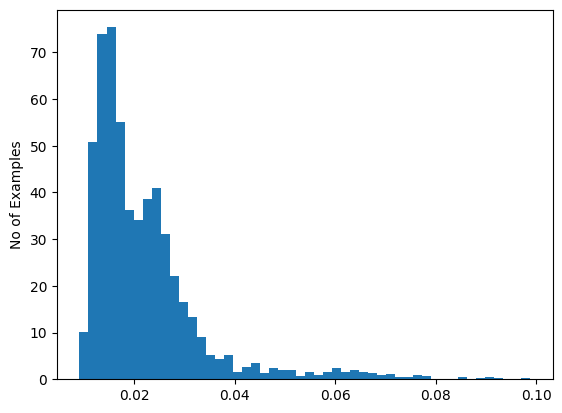

In [30]:
plt.hist(train_loss,bins=50,density=True)
plt.ylabel("No of Examples")
plt.show()

In [31]:
threshold=np.mean(train_loss)+np.std(train_loss)
print("Threshold",threshold)

Threshold 0.033722572


In [32]:
reconstructions=autoencoder.predict(anomalous_test_data)
reconstructions

14/14 [==============================] - 0s 2ms/step


array([[0.4037933 , 0.29749712, 0.2936411 , ..., 0.51331276, 0.52213675,
        0.41606355],
       [0.4047716 , 0.30513158, 0.29252023, ..., 0.5060371 , 0.50287724,
        0.4146859 ],
       [0.4057986 , 0.30483153, 0.29246315, ..., 0.5064715 , 0.50632066,
        0.41570795],
       ...,
       [0.40686163, 0.30773833, 0.2952934 , ..., 0.50603116, 0.5051076 ,
        0.41666627],
       [0.4049431 , 0.306318  , 0.2950948 , ..., 0.5071228 , 0.50399745,
        0.41531226],
       [0.39844784, 0.292188  , 0.2798669 , ..., 0.50790167, 0.5039807 ,
        0.40904963]], dtype=float32)

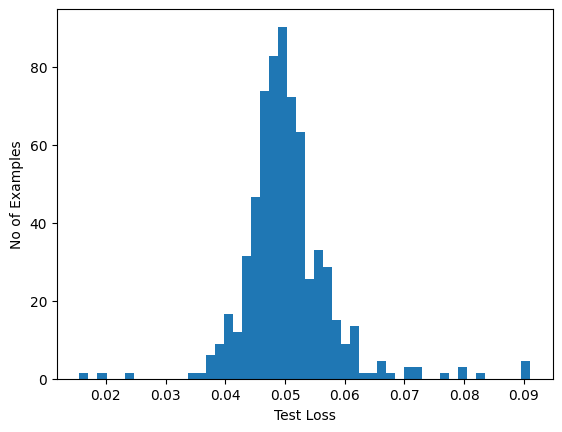

In [33]:
test_loss=tf.keras.losses.mae(reconstructions,anomalous_test_data).numpy()
plt.hist(test_loss,bins=50,density=True)
plt.xlabel("Test Loss")
plt.ylabel("No of Examples")
plt.show()

def predict(model,data,threshold):
    reconstructions=model(data)
    loss=tf.keras.losses.mae(reconstructions,data)
    return tf.math.less(loss,threshold)#返回loss小于threshold的真值
def print_stats(prediction,labels):
    print("Accuracy={}".format(accuracy_score(labels,preds)))
    print("Precision={}".format(precision_score(labels,preds)))
    print("Recall={}".format(recall_score(labels,preds)))
preds=predict(autoencoder,test_data,threshold)
print_stats(preds,test_labels)